Sorry pour le nom du notebook

In [38]:
from utils import *
current_dir = os.curdir
dataPath = current_dir + "/vrai_test_escalier_17_avril.txt"

data = load_data(dataPath)

data_centre_path = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_centre_2023-04-19.txt"
data_centre = load_data(data_centre_path)

data_left5w = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_gauche_5W_1min_-5mm_2023-04-19.txt"
data_left5w = load_data(data_left5w)

data_up5w = "/Users/sammynoelparise/Library/CloudStorage/OneDrive-UniversitéLaval/Sixième session/Design/Design 3 Team 2/Programmation/Debuggage/DATA/echelon_haut_5W_1min.txt"
data_up5w = load_data(data_up5w)

In [39]:
#discard index [4, 11, 12, 13, 25, 26, 27, 44, 45, 46, 47, 'ref1', 'ref2' , 'ref3']

data.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_centre.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_left5w.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)
data_up5w.drop(['4', '11', '12', '13', '25', '26', '27', '44', '45', '46', '47', 'ref1', 'ref2' , 'ref3', '28', '48','101','59', '102', '32'], axis=1, inplace=True)

In [40]:

data_temp = convert_to_temp(data)
data_centre_temp = convert_to_temp(data_centre)
data_left5w_temp = convert_to_temp(data_left5w)
data_up5w_temp = convert_to_temp(data_up5w)

highest_temp = rank_temperature(data_temp)
highest_temp_centre = rank_temperature(data_centre_temp)
highest_temp_left5w = rank_temperature(data_left5w_temp)
highest_temp_up5w = rank_temperature(data_up5w_temp)


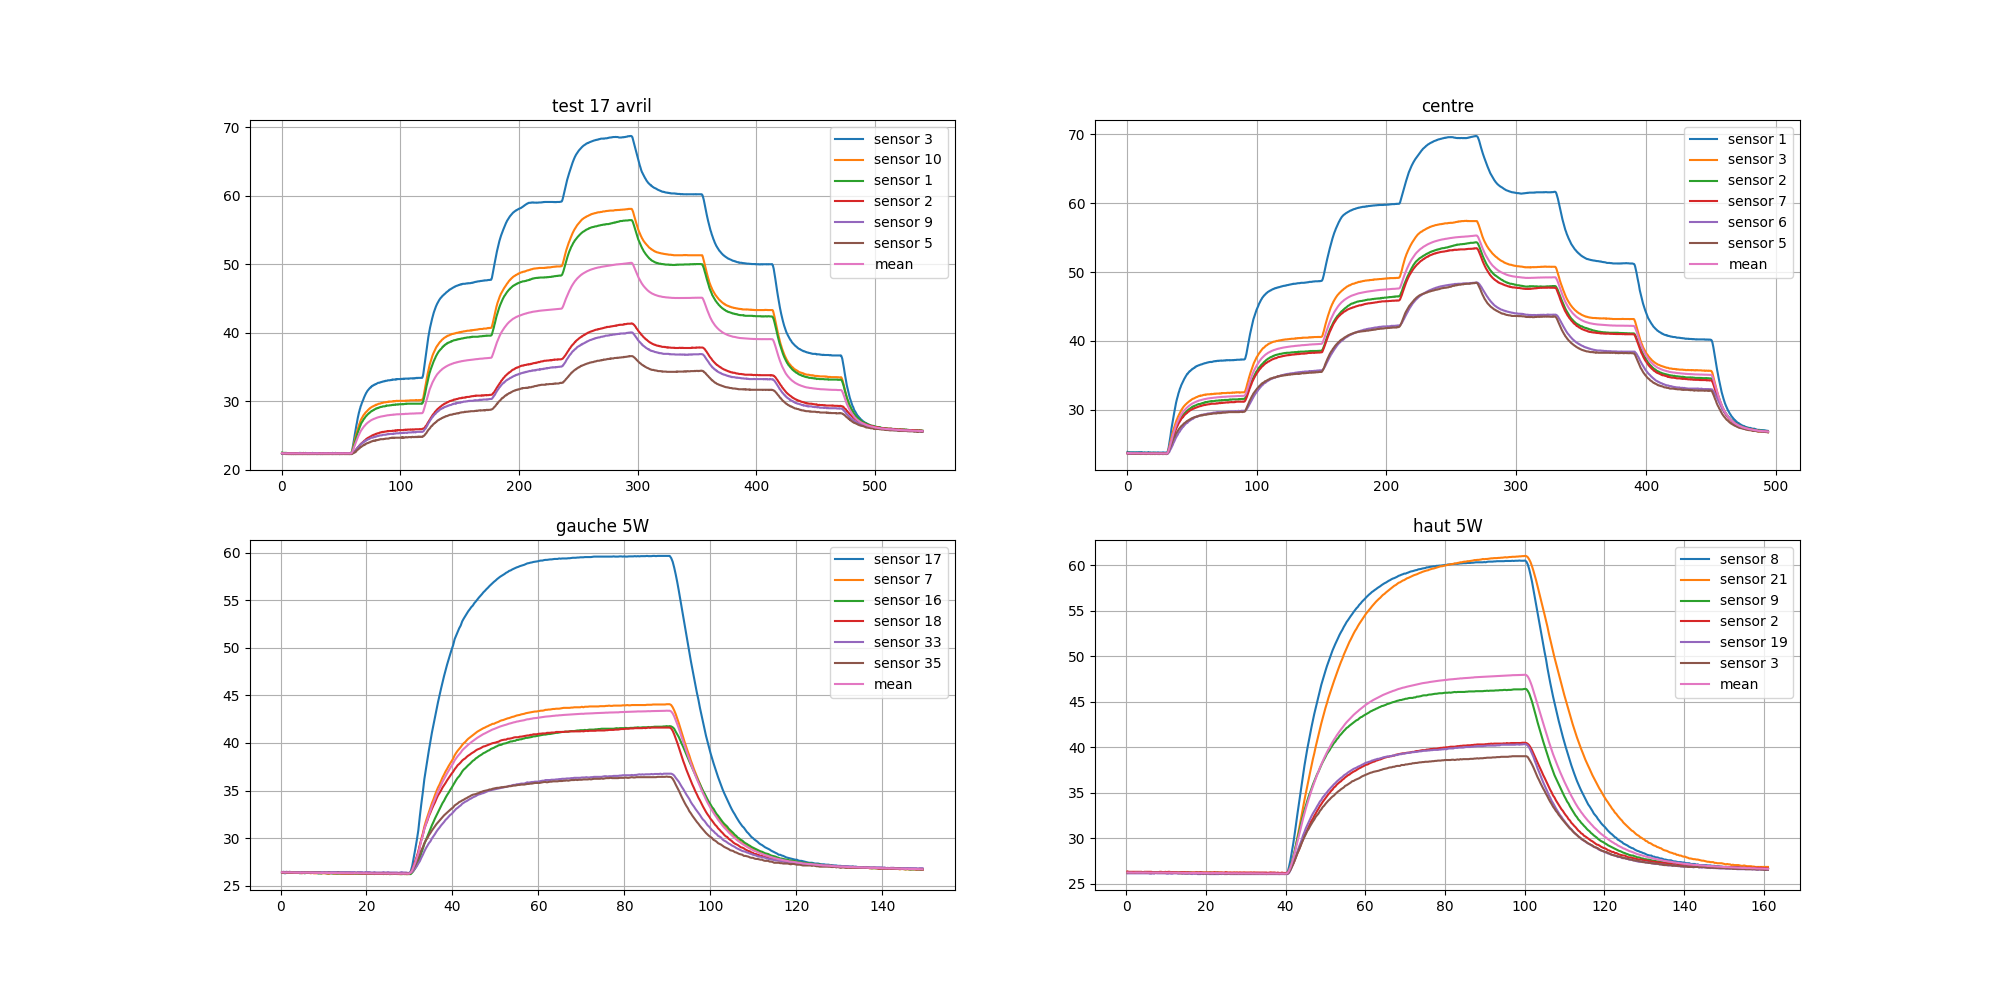

In [41]:
def plot(ax, data, temperature_rank, n, title="", mean=False):
    """
    ax: axis to plot on
    data: data to plot
    temperature_rank: rank of the temperature to plot
    n: number of data to plot
    """
    for i in range(n):
        index = temperature_rank[i]
        ax.plot(data["time"], data[index], label="sensor " + str(index))
    if mean:
        ax.plot(data["time"], data[temperature_rank[:n]].mean(axis=1), label="mean")
    ax.legend()
    ax.set_title(title)
    ax.grid()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
n=6
plot(ax[0, 0], data_temp, highest_temp, n, "test 17 avril", mean = True)
plot(ax[0, 1], data_centre_temp, highest_temp_centre, n, "centre", mean=True)
plot(ax[1, 0], data_left5w_temp, highest_temp_left5w, n, "gauche 5W", mean=True)
plot(ax[1, 1], data_up5w_temp, highest_temp_up5w, n, "haut 5W", mean=True)

La valeur mean n'est clairement pas utilisable encore dans cette étape, on va voir après avoir soustrait la référence.

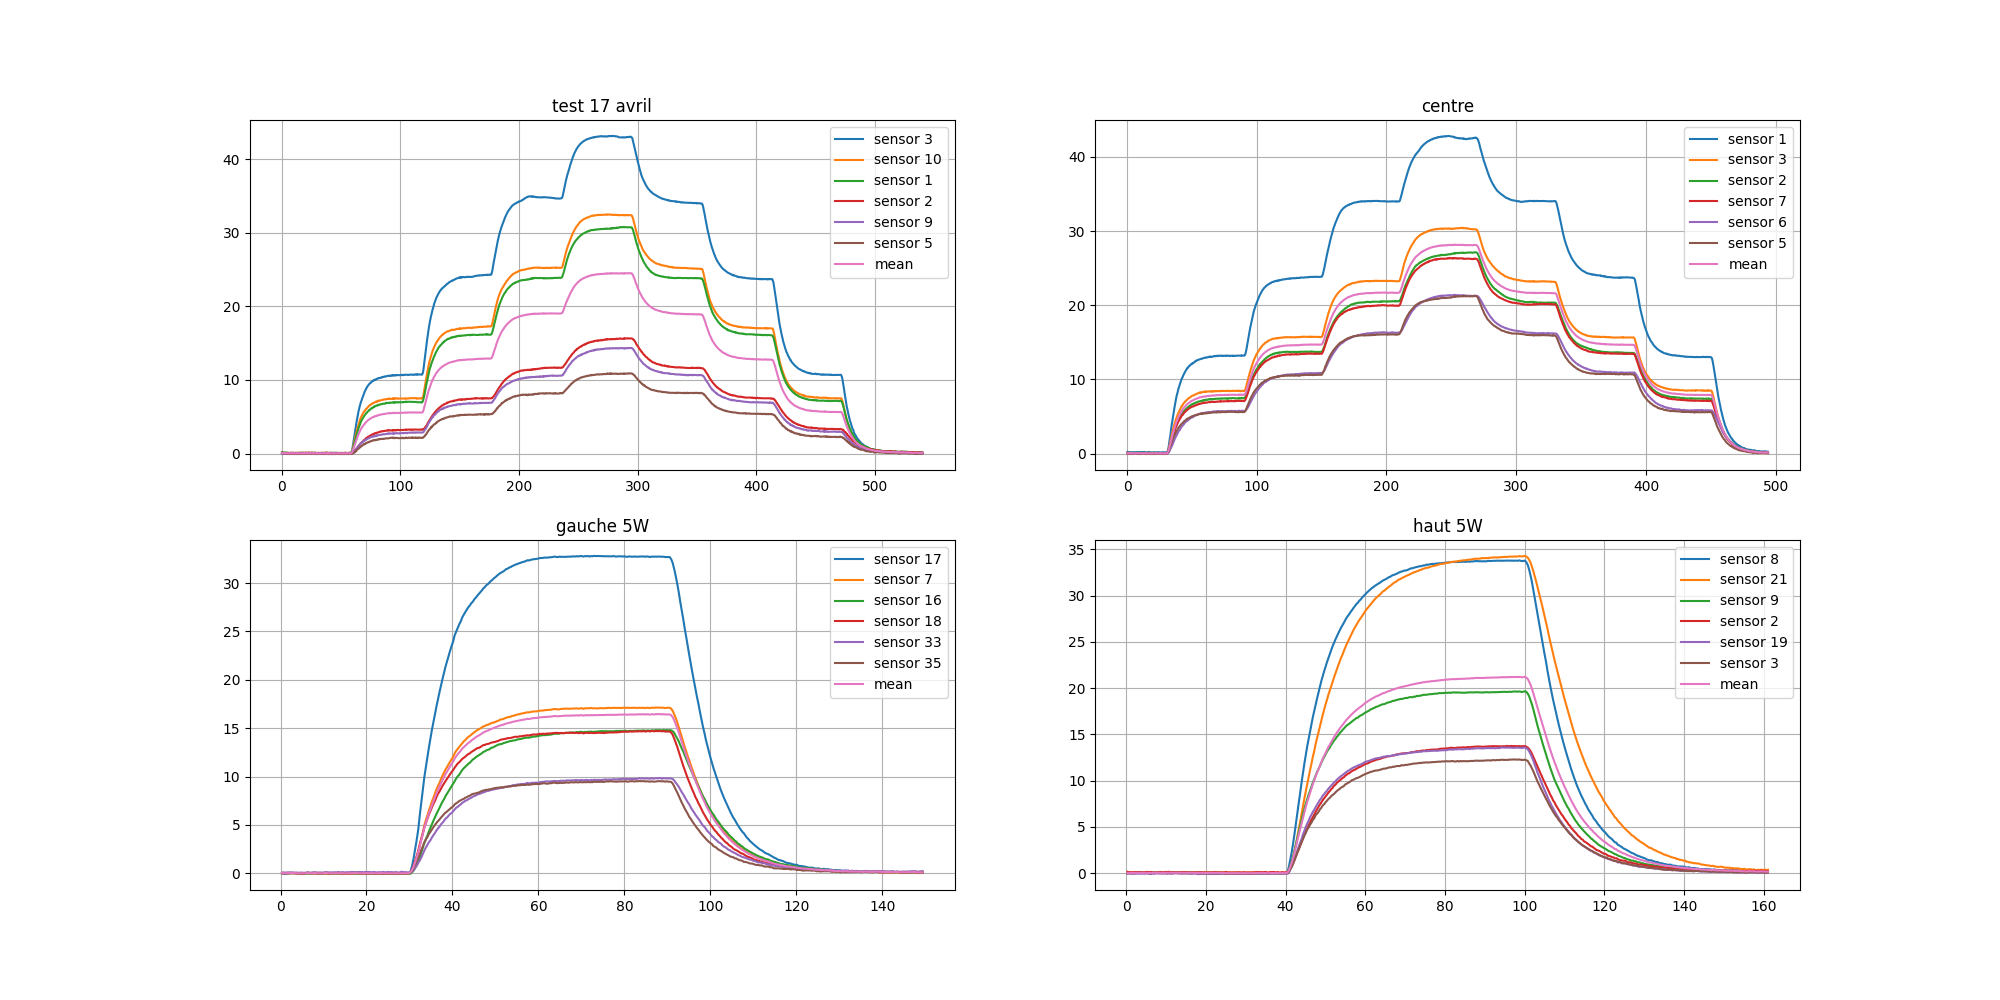

In [42]:
def substract_references(data, temperature_rank, n):
    """
    substract to all data the mean of the n coldest sensors
    """
    data = data.copy()
    data[temperature_rank] = data[temperature_rank].sub(data[temperature_rank[-n:]].mean(axis=1), axis=0)
    return data
delta_t = substract_references(data_temp, highest_temp, 3)
delta_t_centre = substract_references(data_centre_temp, highest_temp_centre, 3)
delta_t_left5w = substract_references(data_left5w_temp, highest_temp_left5w, 3)
delta_t_up5w = substract_references(data_up5w_temp, highest_temp_up5w, 3)
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
n=6
plot(ax[0, 0], delta_t, highest_temp, n, "test 17 avril", mean = True)
plot(ax[0, 1], delta_t_centre, highest_temp_centre, n, "centre", mean=True)
plot(ax[1, 0], delta_t_left5w, highest_temp_left5w, n, "gauche 5W", mean=True)
plot(ax[1, 1], delta_t_up5w, highest_temp_up5w, n, "haut 5W", mean=True)



In [64]:
power = degree3(delta_t[highest_temp[0]], *[8.87865829e-05, -4.81946187e-03,  2.72133515e-01,  2.93516319e-02])
power_centre = degree3(delta_t_centre[highest_temp_centre[0]], *[8.87865829e-05, -4.81946187e-03,  2.72133515e-01,  2.93516319e-02])
power_left5w = degree3(delta_t_left5w[highest_temp_left5w[0]], *[8.87865829e-05, -4.81946187e-03,  2.72133515e-01,  2.93516319e-02])
power_up5w = degree3(delta_t_up5w[highest_temp_up5w[0]], *[8.87865829e-05, -4.81946187e-03,  2.72133515e-01,  2.93516319e-02])
c, d= 5. , 0
power_predicted = predictive_algo(power, c,d, delta=[5,5,5], separation=False)
power_centre_predicted = predictive_algo(power_centre, c,d, delta=[5,5,5], separation=False)
power_left5w_predicted = predictive_algo(power_left5w, c,d, delta=[5,5,5], separation=False)
power_up5w_predicted = predictive_algo(power_up5w, c,d, delta=[5,5,5], separation=False)

kernel_size = 5
kernel = np.ones(kernel_size)/kernel_size
power_convolved = np.convolve(power, kernel, mode='same')
power_centre_convolved = np.convolve(power_centre, kernel, mode='same')
power_left5w_convolved = np.convolve(power_left5w, kernel, mode='same')
power_up5w_convolved = np.convolve(power_up5w, kernel, mode='same')

power_filtered_predicted = predictive_algo(power_convolved, c,d, delta=[5,5,5], separation=False)
power_centre_filtered_predicted = predictive_algo(power_centre_convolved, c,d, delta=[5,5,5], separation=False)
power_left5w_filtered_predicted = predictive_algo(power_left5w_convolved, c,d, delta=[5,5,5], separation=False)
power_up5w_filtered_predicted = predictive_algo(power_up5w_convolved, c,d, delta=[5,5,5], separation=False)


In [65]:
%matplotlib widget

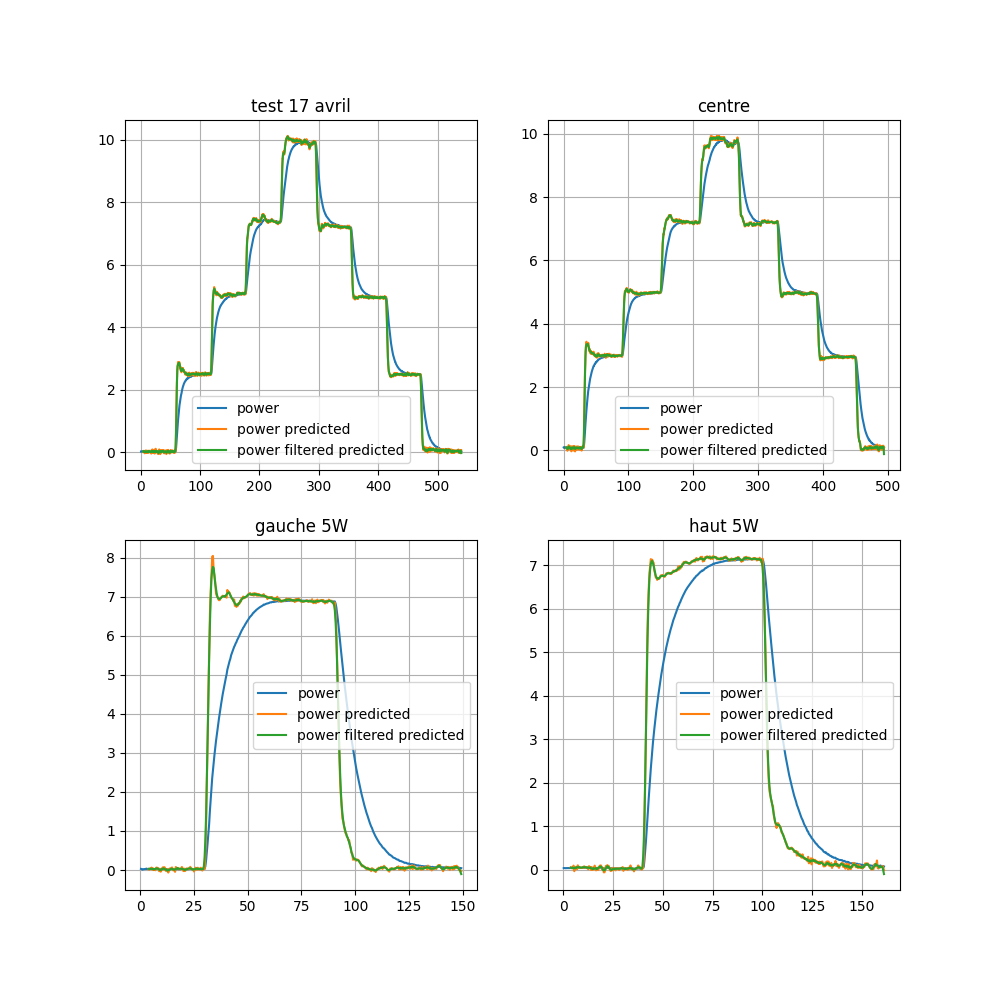

In [66]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(data_temp["time"], power, label="power")
ax[0, 0].plot(data_temp["time"][10:], power_predicted, label="power predicted")
ax[0, 0].plot(data_temp["time"][10:], power_filtered_predicted, label="power filtered predicted")
ax[0, 0].legend()
ax[0, 0].set_title("test 17 avril")
ax[0, 0].grid()
ax[0, 1].plot(data_centre_temp["time"], power_centre, label="power")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted, label="power predicted")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_filtered_predicted, label="power filtered predicted")
ax[0, 1].legend()
ax[0, 1].set_title("centre")
ax[0, 1].grid()
ax[1, 0].plot(data_left5w_temp["time"], power_left5w, label="power")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted, label="power predicted")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_filtered_predicted, label="power filtered predicted")
ax[1, 0].legend()
ax[1, 0].set_title("gauche 5W")
ax[1, 0].grid()
ax[1, 1].plot(data_up5w_temp["time"], power_up5w, label="power")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted, label="power predicted")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_filtered_predicted, label="power filtered predicted")
ax[1, 1].legend()
ax[1, 1].set_title("haut 5W")
ax[1, 1].grid()

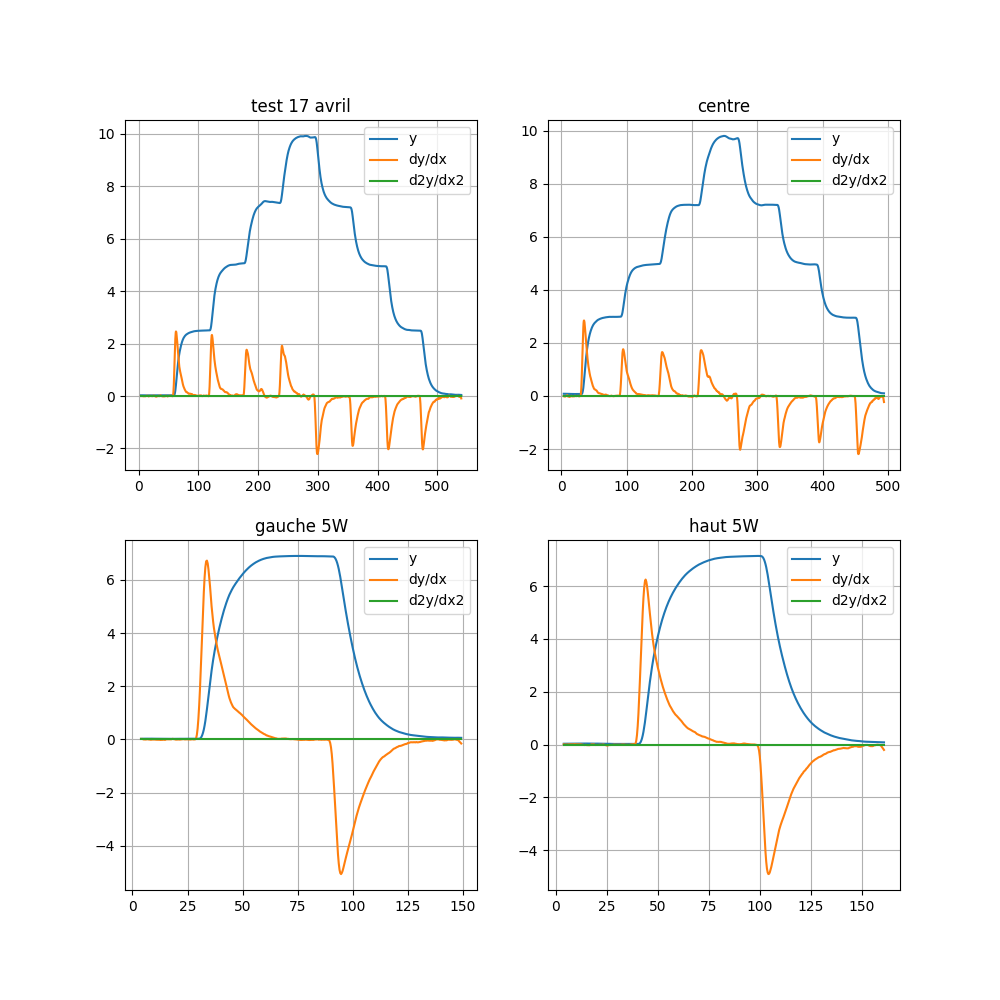

In [56]:
power_predicted_sepate = predictive_algo(power_convolved, c,d, delta=[5,5,5], separation=True)
power_centre_predicted_sepate = predictive_algo(power_centre_convolved, c,d, delta=[5,5,5], separation=True)
power_left5w_predicted_sepate = predictive_algo(power_left5w_convolved, c,d, delta=[5,5,5], separation=True)
power_up5w_predicted_sepate = predictive_algo(power_up5w_convolved, c,d, delta=[5,5,5], separation=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[0], label="y")
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[1], label="dy/dx")
ax[0, 0].plot(data_temp["time"][10:], power_predicted_sepate[2], label="d2y/dx2")
ax[0, 0].legend()
ax[0, 0].set_title("test 17 avril")
ax[0, 0].grid()
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[0], label="y")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[1], label="dy/dx")
ax[0, 1].plot(data_centre_temp["time"][10:], power_centre_predicted_sepate[2], label="d2y/dx2")
ax[0, 1].legend()
ax[0, 1].set_title("centre")
ax[0, 1].grid()
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[0], label="y")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[1], label="dy/dx")
ax[1, 0].plot(data_left5w_temp["time"][10:], power_left5w_predicted_sepate[2], label="d2y/dx2")
ax[1, 0].legend()
ax[1, 0].set_title("gauche 5W")
ax[1, 0].grid()
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[0], label="y")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[1], label="dy/dx")
ax[1, 1].plot(data_up5w_temp["time"][10:], power_up5w_predicted_sepate[2], label="d2y/dx2")
ax[1, 1].legend()
ax[1, 1].set_title("haut 5W")
ax[1, 1].grid()

Bonne nouvelle, les deux du haut semble bien marcher. Ceux décalés en x et en y ont une valeur plus élevée ce qui est attendu. Un paramètre 5/7 devra être ajouté. Jeudi, on refait un test en échelon à 10W à 5mm de chaque bord, en haut et en bas, puis à 2.5mm. En gros, chaque anneau devra avoir sa propre courbe de degrée 3. 

In [46]:
maxvalue = mux1[11]
fig1, ax1 = plt.subplots(1, 1, figsize=(7, 7))
fig, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].plot(time, maxvalue)


deltas = [5, 5, 5]

maxvalue = (4.25 -maxvalue)*6.4

#gaussian_filter1d(maxvalue, sigma=5)
filtered_maxvalue = np.convolve(maxvalue, np.ones((8))/8, mode='same')
ax1.plot(time[10:], maxvalue[10:])
c,d = 6, 3
prediction = predictive_algo(maxvalue, c,d, deltas)
prediction_filtered = predictive_algo(filtered_maxvalue, c,d, deltas)


ax1.plot(time[10:], prediction[0] + prediction[1] + prediction[2])
ax1.plot(time[10:], prediction_filtered[0] + prediction_filtered[1] + prediction_filtered[2])
ax1.grid()
ax[0].plot(time[10:], prediction[0])
ax[1].plot(time[10:], c*prediction[1])
ax[2].plot(time[10:], d*prediction[2])

NameError: name 'mux1' is not defined

In [ ]:
dataPath = current_dir + "/DataLabo2_2023-04-18.txt"
#skip first line, and use tab as separator

data = pd.read_csv(dataPath, sep = "\t", skiprows = 1, header = None)

In [ ]:
#add column names
columns = ["time", "power", "x", "y", "tension", 'temp',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
            '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
            '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
            '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']
data.columns = columns
#set time as index

#change type from str to float where , is replaced by .
data = data.replace(',','.', regex=True)
data = data.astype(float)

Optimal Parameters:  [ 4.03469754e-05 -1.76969158e-04  1.80621985e-01 -3.02127127e-02]
Variance : [8.095358921657797e-06, 0.0005133549302755089, 0.008413425514024894, 0.03317887131065051]


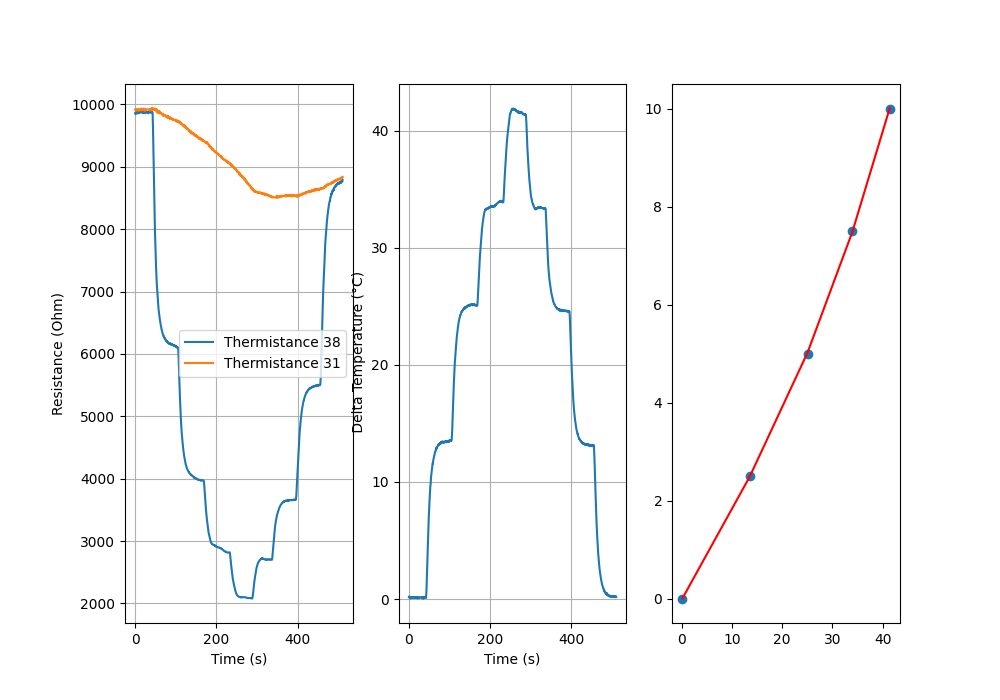

In [ ]:
tensions = np.array(data.iloc[:, 6:])
#get min value in tensions and get indezx
minvalue = np.min(tensions)
minindex = np.argmin(tensions)
#plot the column with the min value
hotter_tension = tensions[:, 38]
hotter_resistance = VtoR(hotter_tension)
hotter_temp = VtoT(hotter_tension)

ref_tension = tensions[:, 31]
ref_resistance = VtoR(ref_tension)
ref_temp = VtoT(ref_tension)

deltaT = hotter_temp - ref_temp

time = data['time']
y1 = [0, 2.5,5,7.5,10]
x = [deltaT[0], deltaT[230], deltaT[372], deltaT[510], deltaT[632]]
x =	np.array(x)

popt = curvefit(x, y1, degree3)


fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].plot(time, hotter_resistance, label="Thermistance 38")
ax[0].plot(time, ref_resistance, label="Thermistance 31")
ax[1].plot(time, deltaT)
ax[0].legend()
#x title
ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Time (s)")
#y title
ax[0].set_ylabel("Resistance (Ohm)")
ax[1].set_ylabel(" Delta Temperature (°C)")
#set x ticks to be every 10 seconds
#ax.set_xticks(np.arange(0, data.index[-1], 10))
ax[2].plot(x, y1, 'o', label='original data')
ax[2].plot(x, degree3(x, *popt), 'r', label='fit')
ax[0].grid()
ax[1].grid()


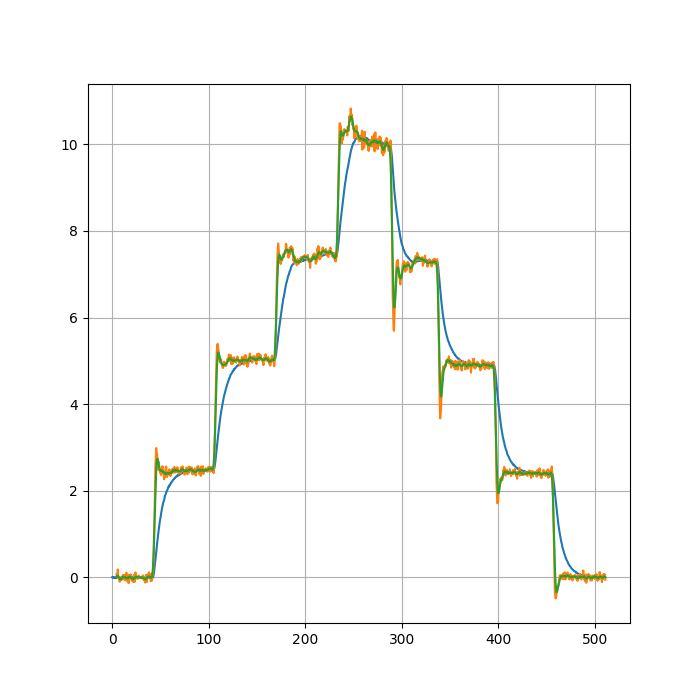

In [ ]:
fi3, ax3 = plt.subplots(1, 1, figsize=(7, 7))
power = degree3(deltaT, *popt)
filtered_power = np.convolve(power, np.ones((8))/8, mode='same')
ax3.plot(time, power)
ax3.grid()
c,d = 4.5, 2
prediction = predictive_algo(power, c,d, [5,5,5])
prediction_filtered = predictive_algo(filtered_power, c,d, [5,5,5])
a = (102-42)/30
ax3.plot(time[10:], prediction[0] + prediction[1] + prediction[2])
ax3.plot(time[10:], prediction_filtered[0] + prediction_filtered[1] + prediction_filtered[2])


In [ ]:
dataPath = current_dir + "/deplacement_profil_2024-04-18.txt"
#skip first line, and use tab as separator

data = pd.read_csv(dataPath, sep = "\t", skiprows = 1, header = None)

In [ ]:
#add column names
columns = ["time", "power", "x", "y", "tension", 'temp',
            '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16',
            '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
            '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
            '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59']
data.columns = columns
#set time as index

#change type from str to float where , is replaced by .
data = data.replace(',','.', regex=True)
data = data.astype(float)
time = data['time']

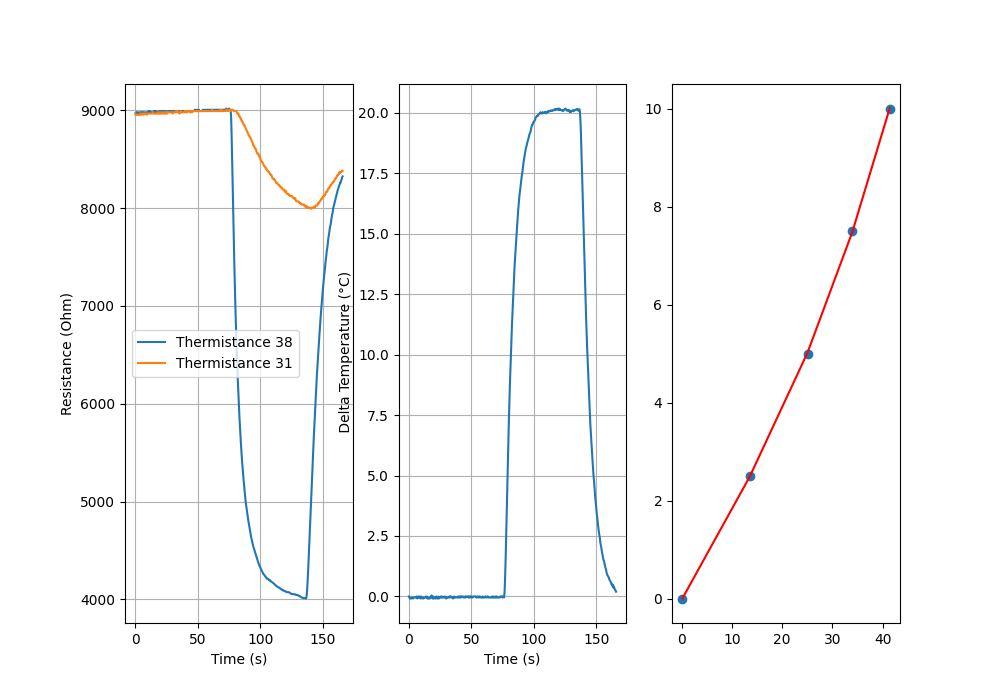

In [ ]:
tensions = np.array(data.iloc[:, 6:])
#get min value in tensions and get indezx
minvalue = np.min(tensions)
minindex = np.argmin(tensions)
#plot the column with the min value
hotter_tension = tensions[:, 33]
hotter_resistance = VtoR(hotter_tension)
hotter_temp = VtoT(hotter_tension)

ref_tension = tensions[:, 3]
ref_resistance = VtoR(ref_tension)
ref_temp = VtoT(ref_tension)

deltaT = hotter_temp - ref_temp

# time = data['time']
# y1 = [0, 2.5,5,7.5,10]
# x = [deltaT[0], deltaT[230], deltaT[372], deltaT[510], deltaT[632]]
# x =	np.array(x)



fig, ax = plt.subplots(1, 3, figsize=(10, 7))
ax[0].plot(time, hotter_resistance, label="Thermistance 38")
ax[0].plot(time, ref_resistance, label="Thermistance 31")
ax[1].plot(time, deltaT)
ax[0].legend()
#x title
ax[0].set_xlabel("Time (s)")
ax[1].set_xlabel("Time (s)")
#y title
ax[0].set_ylabel("Resistance (Ohm)")
ax[1].set_ylabel(" Delta Temperature (°C)")
#set x ticks to be every 10 seconds
#ax.set_xticks(np.arange(0, data.index[-1], 10))
ax[2].plot(x, y1, 'o', label='original data')
ax[2].plot(x, degree3(x, *popt), 'r', label='fit')
ax[0].grid()
ax[1].grid()


0.421


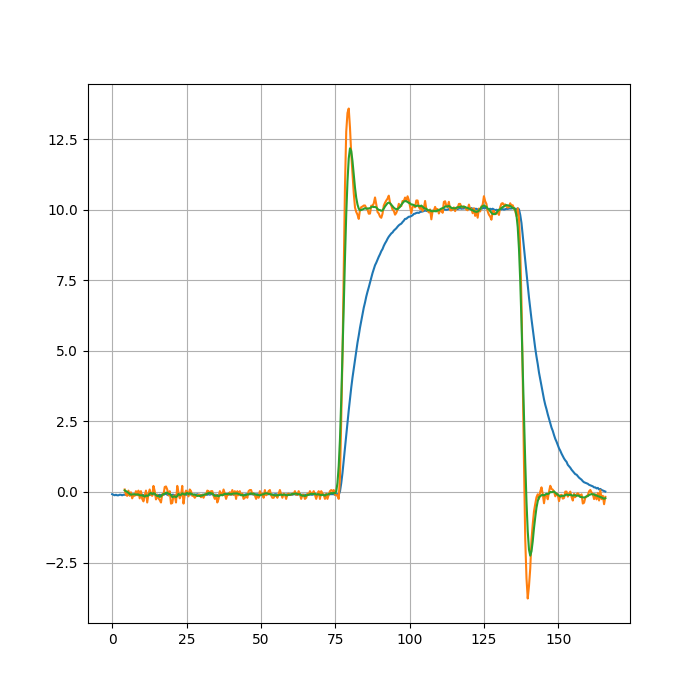

In [ ]:
power = degree3(deltaT, *popt) * 2.6
a = (102-42)/30
fig, ax3 = plt.subplots(1, 1, figsize=(7, 7))
filtered_power = np.convolve(power, np.ones((8))/8, mode='same')
ax3.plot(time, power)
print(time[1]-time[0])
ax3.grid()
c,d = 4.5, 2
prediction = predictive_algo(power, c,d, [5,5,5])
prediction_filtered = predictive_algo(filtered_power, c,d, [5,5,5])

ax3.plot(time[10:], prediction[0] + prediction[1] + prediction[2])
ax3.plot(time[10:], prediction_filtered[0] + prediction_filtered[1] + prediction_filtered[2])